# Image Recognition Demo

## Step 1: Initialise GPU

In [19]:
import torch
import time
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision import datasets 
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# If GPU is available, the print will show 'cuda'. Otherwise it will show 'cpu'
print(device)

cuda


## Step 2: Prepare dataset

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True, #for training
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=4, #process only 4 images at a time
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False, #not for training
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=4, #process only 4 images at a time
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Step 3: Visualise some training images

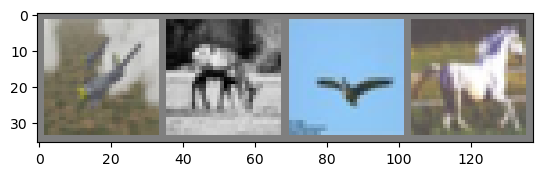

plane  deer  bird horse


In [6]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print true labels of the images
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Step 4: Define the network architecture

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

## Step 5: Set the training parameters and optimizer

In [8]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(net.parameters(), lr=0.0005) #lr: learning rate

## Step 6: Train the network

In [9]:
# #training

# net.to(device)

# start_time = time.time()

# loss_history = []
# epoch = 50
# for e in range(epoch):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data[0].to(device), data[1].to(device)

#         # set the parameter gradients to zero
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print('epoch: %d, baches: %5d, loss: %.3f' %
#                   (e + 1, i + 1, running_loss / 2000))
#             loss_history.append(running_loss)
#             running_loss = 0.0

# print('Finished Training')

# print('Training time in %s seconds ---' % (time.time() - start_time))

# plt.plot(loss_history, label = 'training loss', color = 'r')
# plt.legend(loc = 'upper left')
# plt.show()

# # Save the network after training to file
# # PATH = './cifar_net.pth'
# # torch.save(net.state_dict(), PATH)

## Step 7: Test the network with some test samples

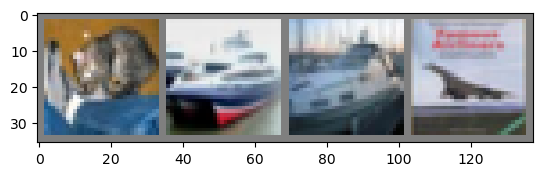

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


In [10]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# show images and print ground-truth labels
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

net = Net() #create a network
PATH = './cifar_net.pth'
net.load_state_dict(torch.load(PATH)) #load the trained network
net.to(device)

outputs = net(images.to(device)) #test the network with inputs as images

_, predicted_labels = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted_labels[j]]
                              for j in range(4)))

## Step 8: Evaluate the network on the entire test set

In [13]:
#load the trained network
net = Net()
net.load_state_dict(torch.load(PATH))

#testing
net.to(device)

start_time = time.time()

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, groundtruth_labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted_labels = torch.max(outputs.data, 1)
        total += groundtruth_labels.size(0)
        correct += (predicted_labels == groundtruth_labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

print("Testing time is in %s seconds ---" % (time.time() - start_time))

Accuracy of the network on the 10000 test images: 64 %
Testing time is in 33.06029438972473 seconds ---


In [14]:
class_correct = list(0. for i in range(10)) 
class_total = list(0. for i in range(10)) 
with torch.no_grad(): 
    for data in testloader: 
        images, groundtruth_labels = data[0].to(device), data[1].to(device) 
        outputs = net(images) 
        _, predicted_labels = torch.max(outputs, 1) 
        c = (predicted_labels == groundtruth_labels).squeeze() 
        for i in range(4): 
            label = groundtruth_labels[i] 
            class_correct[label] += c[i].item() 
            class_total[label] += 1 
 
for i in range(10): 
    print('Accuracy of %5s : %2d %%' % ( 
        classes[i], 100 * class_correct[i] / class_total[i])) 

Accuracy of plane : 63 %
Accuracy of   car : 78 %
Accuracy of  bird : 58 %
Accuracy of   cat : 38 %
Accuracy of  deer : 51 %
Accuracy of   dog : 54 %
Accuracy of  frog : 78 %
Accuracy of horse : 68 %
Accuracy of  ship : 81 %
Accuracy of truck : 73 %


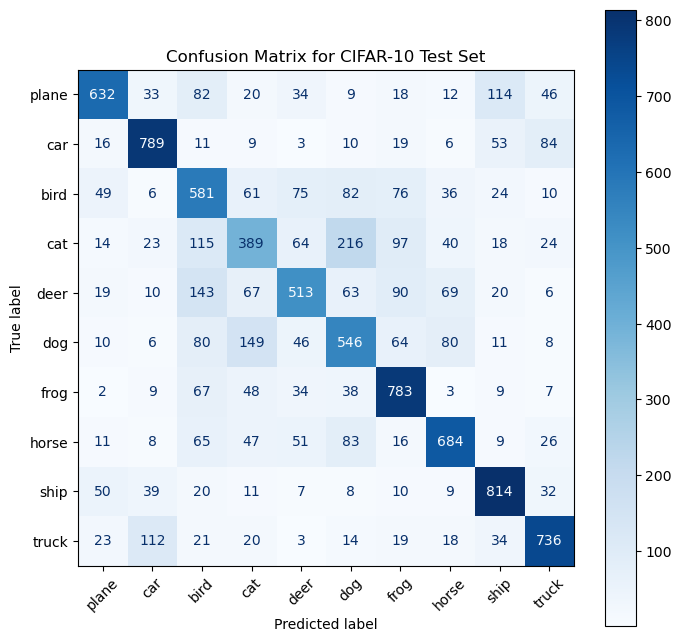

In [18]:
# Step 9: Calculate and display the confusion matrix for the test set

all_groundtruth = []
all_predicted = []

with torch.no_grad():
    for data in testloader:
        images, groundtruth_labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted_labels = torch.max(outputs, 1)
        all_groundtruth.extend(groundtruth_labels.cpu().numpy())
        all_predicted.extend(predicted_labels.cpu().numpy())

cm = confusion_matrix(all_groundtruth, all_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix for CIFAR-10 Test Set')
plt.show()

## Step 10: Train and evaluate a neural network on the FoodImages dataset
We will use the same architecture as for CIFAR-10, but you are free to experiment with different architectures and learning parameters to maximize performance. The following code will train the model, report the overall accuracy, and display the confusion matrix for the test set.

Epoch 5/30, Loss: 16.285
Epoch 10/30, Loss: 11.730
Epoch 15/30, Loss: 5.279
Epoch 20/30, Loss: 2.658
Epoch 25/30, Loss: 0.773
Epoch 30/30, Loss: 0.156
Finished Training FoodNet


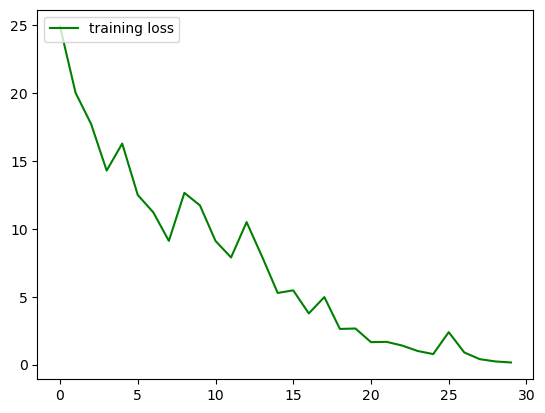

Accuracy of FoodNet on the test images: 75.56 %


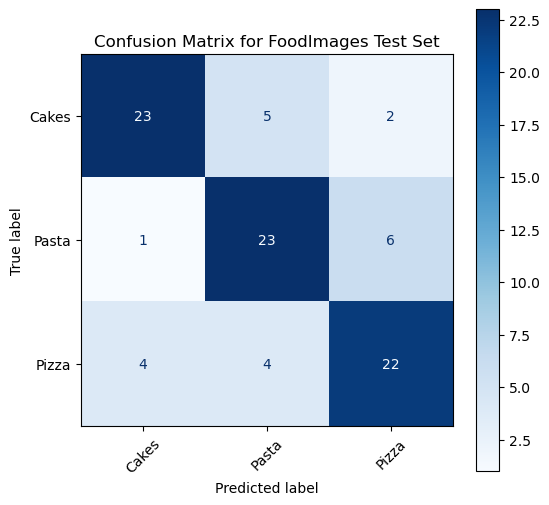

In [21]:
# Define trainset, testset, and classes for FoodImages dataset

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset_food = datasets.ImageFolder('FoodImages/Train', transform=transform)
testset_food = datasets.ImageFolder('FoodImages/Test', transform=transform)

trainloader_food = torch.utils.data.DataLoader(trainset_food, batch_size=4, shuffle=True, num_workers=2)
testloader_food = torch.utils.data.DataLoader(testset_food, batch_size=4, shuffle=False, num_workers=2)

food_classes = ('Cakes', 'Pasta', 'Pizza')

# Define the network (same as CIFAR-10, but output size = 3)
class FoodNet(nn.Module):
    def __init__(self):
        super(FoodNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

food_net = FoodNet().to(device)

criterion_food = nn.CrossEntropyLoss().to(device)
optimizer_food = optim.AdamW(food_net.parameters(), lr=0.001)

# Train the network
num_epochs = 30
loss_history_food = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader_food, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer_food.zero_grad()
        outputs = food_net(inputs)
        loss = criterion_food(outputs, labels)
        loss.backward()
        optimizer_food.step()
        running_loss += loss.item()
    loss_history_food.append(running_loss)
    if (epoch+1) % 5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.3f}')

# # Save the network after training to file
# PATH = './foodimage_net.pth'
# torch.save(food_net.state_dict(), PATH)

Finished Training FoodNet


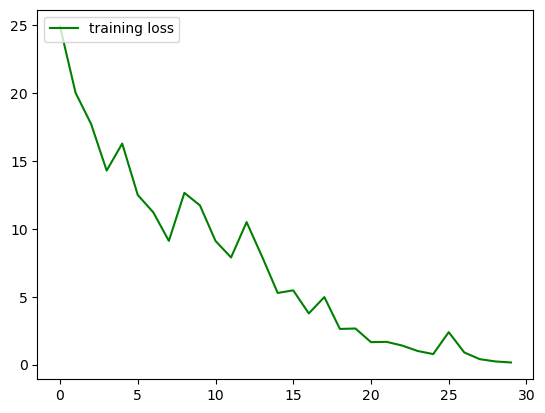

In [22]:
print('Finished Training FoodNet')
plt.plot(loss_history_food, label='training loss', color='g')
plt.legend(loc='upper left')
plt.show()

In [25]:
# Evaluate on test set
#load the trained network
food_net = FoodNet()
PATH = './foodimage_net.pth'
food_net.load_state_dict(torch.load(PATH))

#testing
food_net.to(device)

food_net.eval()
correct = 0
total = 0
all_groundtruth_food = []
all_predicted_food = []
with torch.no_grad():
    for data in testloader_food:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = food_net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_groundtruth_food.extend(labels.cpu().numpy())
        all_predicted_food.extend(predicted.cpu().numpy())

print(f'Accuracy of FoodNet on the test images: {100 * correct / total:.2f} %')

Accuracy of FoodNet on the test images: 75.56 %


In [26]:
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))
with torch.no_grad():
    for data in testloader_food:
        images, groundtruth_labels = data[0].to(device), data[1].to(device)
        outputs = food_net(images)
        _, predicted_labels = torch.max(outputs, 1)
        c = (predicted_labels == groundtruth_labels).squeeze()
        for i in range(len(groundtruth_labels)):
            label = groundtruth_labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(3):
    print('Accuracy of %7s : %2d %%' % (
        food_classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of   Cakes : 76 %
Accuracy of   Pasta : 76 %
Accuracy of   Pizza : 73 %


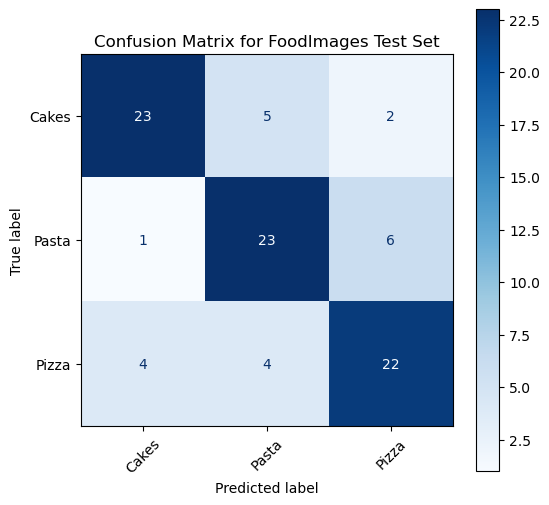

In [27]:
cm_food = confusion_matrix(all_groundtruth_food, all_predicted_food)
disp_food = ConfusionMatrixDisplay(confusion_matrix=cm_food, display_labels=food_classes)
fig, ax = plt.subplots(figsize=(6, 6))
disp_food.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix for FoodImages Test Set')
plt.show()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)
Epoch 5/30, Loss: 4.883
Epoch 5/30, Loss: 4.883
Epoch 10/30, Loss: 0.710
Epoch 10/30, Loss: 0.710
Epoch 15/30, Loss: 0.197
Epoch 15/30, Loss: 0.197
Epoch 20/30, Loss: 0.086
Epoch 20/30, Loss: 0.086
Epoch 25/30, Loss: 0.049
Epoch 25/30, Loss: 0.049
Epoch 30/30, Loss: 0.033
Finished Fine-tuning
Epoch 30/30, Loss: 0.033
Finished Fine-tuning


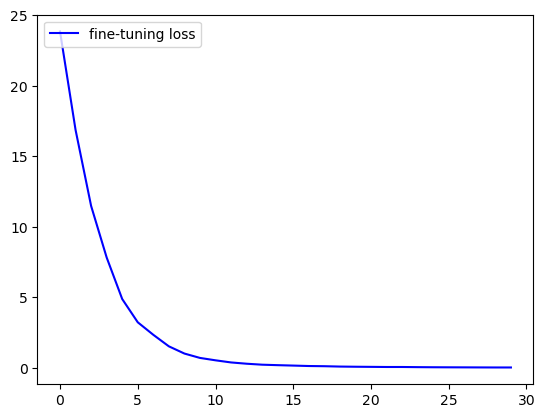

Accuracy of fine-tuned model on FoodImages test images: 76.67 %


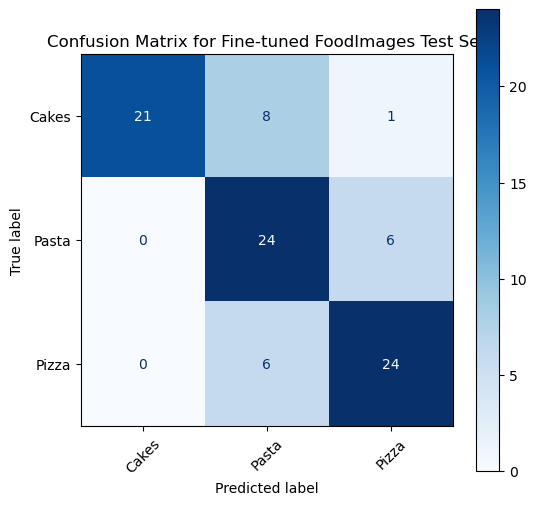

Accuracy of   Cakes : 70 %
Accuracy of   Pasta : 80 %
Accuracy of   Pizza : 80 %


In [33]:
# Fine-tuning CIFAR10 model on FoodImages dataset (replace last layer)
PATH = './cifar_net.pth'
net = Net()
net.load_state_dict(torch.load(PATH))
net.fc3 = nn.Linear(84, 3)
net.to(device)
print(net)

# Set up optimizer and loss for fine-tuning
optimizer_ft = optim.AdamW(net.parameters(), lr=0.0005)
criterion_ft = nn.CrossEntropyLoss().to(device)

# Train the fine-tuned model
num_epochs_ft = 30
loss_history_ft = []
for epoch in range(num_epochs_ft):
    running_loss = 0.0
    for i, data in enumerate(trainloader_food, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer_ft.zero_grad()
        outputs = net(inputs)
        loss = criterion_ft(outputs, labels)
        loss.backward()
        optimizer_ft.step()
        running_loss += loss.item()
    loss_history_ft.append(running_loss)
    if (epoch+1) % 5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs_ft}, Loss: {running_loss:.3f}')

print('Finished Fine-tuning')

plt.plot(loss_history_ft, label='fine-tuning loss', color='b')
plt.legend(loc='upper left')
plt.show()

# Evaluate fine-tuned model on FoodImages test set
net.eval()
correct_ft = 0
total_ft = 0
all_groundtruth_ft = []
all_predicted_ft = []
with torch.no_grad():
    for data in testloader_food:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total_ft += labels.size(0)
        correct_ft += (predicted == labels).sum().item()
        all_groundtruth_ft.extend(labels.cpu().numpy())
        all_predicted_ft.extend(predicted.cpu().numpy())

print(f'Accuracy of fine-tuned model on FoodImages test images: {100 * correct_ft / total_ft:.2f} %')

# Confusion matrix for fine-tuned model
cm_ft = confusion_matrix(all_groundtruth_ft, all_predicted_ft)
disp_ft = ConfusionMatrixDisplay(confusion_matrix=cm_ft, display_labels=food_classes)
fig, ax = plt.subplots(figsize=(6, 6))
disp_ft.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix for Fine-tuned FoodImages Test Set')
plt.show()

# Per-class accuracy for fine-tuned model
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))
with torch.no_grad():
    for data in testloader_food:
        images, groundtruth_labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted_labels = torch.max(outputs, 1)
        c = (predicted_labels == groundtruth_labels).squeeze()
        for i in range(len(groundtruth_labels)):
            label = groundtruth_labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(3):
    print('Accuracy of %7s : %2d %%' % (
        food_classes[i], 100 * class_correct[i] / class_total[i]))

## Comparison: Training from Scratch vs Fine-Tuning on FoodImages Dataset

**Training from Scratch (FoodNet):**
- The model starts with randomly initialized weights and learns features directly from the FoodImages dataset.
- Training typically takes longer to converge and may require more epochs to achieve good accuracy.
- Performance can be limited if the dataset is small or lacks diversity.
- Per-class accuracy and confusion matrix may show more misclassifications, especially for underrepresented classes.

**Fine-Tuning (CIFAR10 Pre-trained Net):**
- The model is initialized with weights learned from the large CIFAR10 dataset, then adapted to FoodImages by replacing the last layer.
- Training converges faster and often achieves higher accuracy, especially when the target dataset is small.
- Per-class accuracy and confusion matrix usually show improved results and fewer misclassifications.
- Transfer learning leverages useful features learned from the source domain, improving generalization.

**Conclusion:**
Fine-tuning a pre-trained model on the FoodImages dataset provides better overall and per-class accuracy, faster convergence, and improved generalization compared to training from scratch. This demonstrates the effectiveness of transfer learning, especially when the target dataset is limited in size or diversity.

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)
conv1 requires_grad: False
conv2 requires_grad: False
Epoch 5/30, Loss: 8.862
Epoch 5/30, Loss: 8.862
Epoch 10/30, Loss: 2.050
Epoch 10/30, Loss: 2.050
Epoch 15/30, Loss: 0.625
Epoch 15/30, Loss: 0.625
Epoch 20/30, Loss: 0.291
Epoch 20/30, Loss: 0.291
Epoch 25/30, Loss: 0.162
Epoch 25/30, Loss: 0.162
Epoch 30/30, Loss: 0.101
Finished Fine-tuning (conv1 & conv2 frozen)
Epoch 30/30, Loss: 0.101
Finished Fine-tuning (conv1 & conv2 frozen)


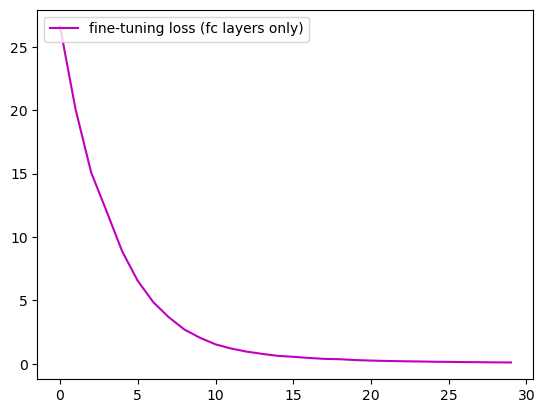

Accuracy of fine-tuned model (fc layers only) on FoodImages test images: 74.44 %


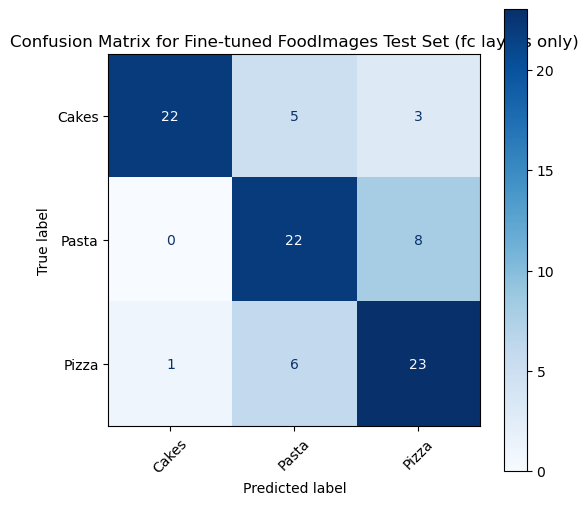

conv1 requires_grad: False
conv2 requires_grad: False
Accuracy of   Cakes : 73 %
Accuracy of   Pasta : 73 %
Accuracy of   Pizza : 76 %
Accuracy of   Cakes : 73 %
Accuracy of   Pasta : 73 %
Accuracy of   Pizza : 76 %


In [34]:
# Fine-tuning CIFAR10 model on FoodImages dataset, freezing conv1 and conv2
PATH = './cifar_net.pth'
net = Net()
net.load_state_dict(torch.load(PATH))
net.fc3 = nn.Linear(84, 3)
net.to(device)
print(net)

# Freeze conv1 and conv2 layers
for param in net.conv1.parameters():
    param.requires_grad = False
for param in net.conv2.parameters():
    param.requires_grad = False

# Update optimizer to only train unfrozen parameters
optimizer_ft = optim.AdamW(filter(lambda p: p.requires_grad, net.parameters()), lr=0.0005)
criterion_ft = nn.CrossEntropyLoss().to(device)

# Print conv1 and conv2 parameters before training
print('conv1 requires_grad:', net.conv1.weight.requires_grad)
print('conv2 requires_grad:', net.conv2.weight.requires_grad)

# Train the fine-tuned model
num_epochs_ft = 30
loss_history_ft = []
for epoch in range(num_epochs_ft):
    running_loss = 0.0
    for i, data in enumerate(trainloader_food, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer_ft.zero_grad()
        outputs = net(inputs)
        loss = criterion_ft(outputs, labels)
        loss.backward()
        optimizer_ft.step()
        running_loss += loss.item()
    loss_history_ft.append(running_loss)
    if (epoch+1) % 5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs_ft}, Loss: {running_loss:.3f}')

print('Finished Fine-tuning (conv1 & conv2 frozen)')

plt.plot(loss_history_ft, label='fine-tuning loss (fc layers only)', color='m')
plt.legend(loc='upper left')
plt.show()

# Evaluate fine-tuned model on FoodImages test set
net.eval()
correct_ft = 0
total_ft = 0
all_groundtruth_ft = []
all_predicted_ft = []
with torch.no_grad():
    for data in testloader_food:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total_ft += labels.size(0)
        correct_ft += (predicted == labels).sum().item()
        all_groundtruth_ft.extend(labels.cpu().numpy())
        all_predicted_ft.extend(predicted.cpu().numpy())

print(f'Accuracy of fine-tuned model (fc layers only) on FoodImages test images: {100 * correct_ft / total_ft:.2f} %')

# Confusion matrix for fine-tuned model
cm_ft = confusion_matrix(all_groundtruth_ft, all_predicted_ft)
disp_ft = ConfusionMatrixDisplay(confusion_matrix=cm_ft, display_labels=food_classes)
fig, ax = plt.subplots(figsize=(6, 6))
disp_ft.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix for Fine-tuned FoodImages Test Set (fc layers only)')
plt.show()

# Print conv1 and conv2 parameters after training
print('conv1 requires_grad:', net.conv1.weight.requires_grad)
print('conv2 requires_grad:', net.conv2.weight.requires_grad)

# Per-class accuracy for fine-tuned model (fc layers only)
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))
with torch.no_grad():
    for data in testloader_food:
        images, groundtruth_labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted_labels = torch.max(outputs, 1)
        c = (predicted_labels == groundtruth_labels).squeeze()
        for i in range(len(groundtruth_labels)):
            label = groundtruth_labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(3):
    print('Accuracy of %7s : %2d %%' % (
        food_classes[i], 100 * class_correct[i] / class_total[i]))